# Introdução


Vamos usar os conhecimentos sobre Validação para encontrar o melhor valor de vizinhos mais próximos para um classificador ```KNeighborsClassifier```. Lembre que mostramos algumas formas de validar modelos de machine learning, que nada mais é um processo de estimar o erro/performance que um modelo terá em produção. A partir dos resultados, podemos checar se o modelo sofre de overfitting ou underfitting. Vamos utilizar essa mesma técnica para identificar de que formas podemos melhorar nosso modelo.



# Setup

In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split,learning_curve,KFold, StratifiedKFold, LeaveOneOut, cross_validate, validation_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss, make_scorer
import matplotlib.pyplot as plt

In [2]:
#dados
df_churn = pd.read_csv('churn.csv')
df_churn.drop(['State' , 'International plan' , 'Voice mail plan'] , axis=1 , inplace = True)

In [3]:
df_churn['Churn'] = df_churn['Churn'].map({False:0, True:1})
X , y = df_churn.drop('Churn' , axis=1), df_churn['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=123)

Antes de tudo, vamos preparar nossos Folds de validação cruzada. Vamos preparar a validação KFold, KFold-Estratificada e Leave One Out.

In [4]:
#K Fold
cv_kfold = KFold(n_splits=10, shuffle= True, random_state=123)
#K Fold Estratificado
cv_kfold_stratified = StratifiedKFold(n_splits=10 , shuffle = True , random_state=123)
# Leave one out
cv_leave_one_out = LeaveOneOut()

In [5]:
#Pipeline

knn_baseline = Pipeline(steps=[('pre_processor' , MinMaxScaler()),
                              ('model', KNeighborsClassifier())])

## KFold

In [6]:
cv_kfold_results = cross_validate(estimator=knn_baseline,
                                 X=X_train,
                                 y=y_train,
                                 scoring='neg_log_loss',
                                 cv=cv_kfold,
                                 return_train_score=True,
                                 n_jobs=-1)

In [7]:
train_scores_cv_kfold_default = cv_kfold_results['train_score']
test_scores_cv_kfold_default = cv_kfold_results['test_score']
print(f'Log Loss Modelo Default - KFold Treino: {np.mean(train_scores_cv_kfold_default)}')
print(f'Log Loss Modelo Default - KFold Teste: {np.mean(test_scores_cv_kfold_default)}')

Log Loss Modelo Default - KFold Treino: -0.18788942989904733
Log Loss Modelo Default - KFold Teste: -1.6946757956069116


Houve Overfiting

## KFold Estratificada

In [8]:
cv_kfold_stratified_results = cross_validate(estimator=knn_baseline,
                                            X=X_train,
                                            y=y_train,
                                            scoring='neg_log_loss',
                                            return_train_score=True,
                                            n_jobs=-1)

In [9]:
train_scores_cv_kfold_stratified_default = cv_kfold_stratified_results['train_score']
test_scores_cv_kfold_stratified_default = cv_kfold_stratified_results['test_score']
print(f'Log Loss Modelo Default - Kfold Stratified Treino: {np.mean(train_scores_cv_kfold_stratified_default)}')
print(f'Log Loss Modelo Default - Kfold Stratified Teste: {np.mean(test_scores_cv_kfold_stratified_default)}')

Log Loss Modelo Default - Kfold Stratified Treino: -0.18977570092074364
Log Loss Modelo Default - Kfold Stratified Teste: -1.6941870894194788


A performance da KFold estratificada foi um pouco pior no Teste. Lembre que quando utilizamos o Log loss como métrica, quanto mais perto de zero melhor. Isso pode ser um indício de desbalanceamento nos folds não estrtificados.

## Leave One Out

In [10]:
def loss_scorer(y_true, y_pred, eps=1e-15, normalize=True, sample_weight=None, labels=None):
    return -log_loss(y_true, y_pred, eps, normalize, sample_weight, labels=__LABELS__)
global __LABELS__
__LABELS__ = list(set(df_churn['Churn']))
scorer_loss = make_scorer(loss_scorer, greater_is_better=True, needs_proba=True)

In [11]:
cv_loo_default_results = cross_validate(estimator=knn_baseline,
                                               X=X_train,
                                               y=y_train,
                                               scoring=scorer_loss,
                                               cv=cv_leave_one_out,
                                               return_train_score=True,
                                               n_jobs=-1)

In [12]:
train_scores_cv_loo_default = cv_loo_default_results['train_score']
test_scores_cv_default = cv_loo_default_results['test_score']
print(f'Log Loss Modelo Default - KFold Stratified Treino: {np.mean(train_scores_cv_loo_default)}')
print(f'Log Loss Modelo Default - KFold Stratified Teste: {np.mean(test_scores_cv_default)}')

Log Loss Modelo Default - KFold Stratified Treino: nan
Log Loss Modelo Default - KFold Stratified Teste: nan


In [13]:
knn_baseline.fit(X_train, y_train)
print(f'log loss treino baseline: {-log_loss(y_train, knn_baseline.predict_proba(X_train))}')
print(f'log loss teste baseline: {-log_loss(y_test, knn_baseline.predict_proba(X_test))}')

log loss treino baseline: -0.1870362137489609
log loss teste baseline: -1.8030285835689726


# Otimização dos K-Vizinhos

vamos criar uma lista de parâmetros com vários valores de vizinhos mais próximos e tentar obter o melhor, baseando-se na ```validation_curve```.

In [14]:
param_range = list(np.arange(1,101, 2))
param_name = 'model__n_neighbors'

Vamos criar uma função auxiliar que irá realizar os cálculos da ```validation_curve``` e ao mesmo tempo plotar o gráfico.

In [15]:
def cross_validation(estimator=None, X=None, y=None, param_name=None, param_range=None, scoring=None, cv=None):
    
    train_score, val_score = validation_curve(estimator=estimator, 
                                          X=X, 
                                          y=y, 
                                          param_name=param_name, 
                                          param_range=param_range,
                                          scoring=scoring,
                                          n_jobs=-1,
                                          cv=cv) 

    plt.figure(figsize=(8,6))
    # plotando as curvas de teste e validação
    plt.plot(param_range, np.mean(train_score,1), color='blue', label='training score')
    plt.plot(param_range, np.mean(val_score, 1), color='red', label='validation score')
    plt.legend(loc='best')
    plt.xlabel('Param_Range')
    plt.ylabel('Score')
    best_param = param_range[np.argmax(np.mean(val_score,1))]
    return best_param

## KFold Estratificado

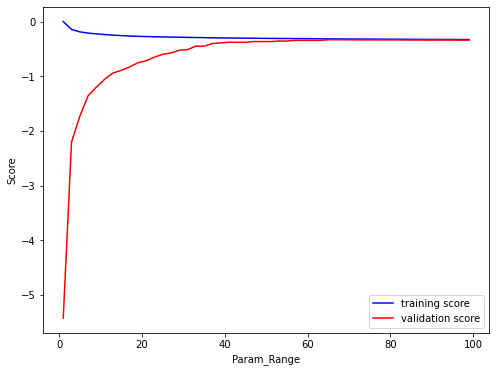

In [16]:
best_param_kfold_stratified = cross_validation(estimator=knn_baseline,
                                             X=X_train, y=y_train, 
                                             param_name=param_name, 
                                             param_range=param_range,
                                             scoring='neg_log_loss',
                                             cv=cv_kfold_stratified)

In [17]:
print(f'O melhor k para o KFold estratificado é: {best_param_kfold_stratified}')

O melhor k para o KFold estratificado é: 65


In [18]:
knn_65_neighbors = knn_baseline.set_params(model__n_neighbors=65)
knn_65_neighbors.fit(X_train, y_train)

Pipeline(steps=[('pre_processor', MinMaxScaler()),
                ('model', KNeighborsClassifier(n_neighbors=65))])

In [19]:
print(f'log loss treino 65: {-log_loss(y_train, knn_65_neighbors.predict_proba(X_train))}')
print(f'log loss teste 65: {-log_loss(y_test, knn_65_neighbors.predict_proba(X_test))}')

log loss treino 65: -0.3130393180618041
log loss teste 65: -0.343496810240607


# Curva de Aprendizado

Já falamos um pouco sobre trade-off viés-variância. Temos sempre que encontrar um balanço entre os dois, buscando um modelo que não é nem tão complexo nem tão simples pra resolver nosso problema. Se um modelo é  muito simpoles, não vai conseguir ser flexível o suficiente para capturar os padrões dos dados, ao passo que um modelo muito complexo, que é muito flexível, vai acabar se ajustando demais aos dados de treino e é muito sensível a eles, de forma que ele acaba decorando o ruído e não generalizando bem para dados de produção.



O que você pode fazer, caso seu modelo não fique bom depois da modelagem? Há algumas coisas que é possível fazer, quando isso ocorre:
- Coletar mais dados
- Diminuir o conjunto de features. Isso mesmo, diminuir o conjunto de features vai reduzir a complexidade de um modelo, diminuindo a propensão ao overfitting.
- Aumentar o conjunto de features. Poder ser pela coleta de mais colunas ou então pela criação, por meio do processo de feature engineering que vimos. Isso aumentará a complexidade do modelo, o que reduzirá underfitting.
- Redução de regularização. A redução de regularização varia de modelo para modelo. No SVM, por exemplo, a regularização é o parâmetro C. Mas há outros parâmetros em outros modelos, que fazem esse papel.Isso aumentará a complexidade do modelo e reduzirá a propensão a underfitting.
- Aumento de regularização. O aumento de regularização, por sua vez, nos traz um redução de complexidade, o que ajudará em casos de overfitting.



Maravilha, agora sabemos como agir diante de um modelo ruim. Mas a questão que fica é:
Como sabemos qual desses métodos tentar primeiro?. 
A resposta é simples: Depende. Vai depender se o seu modelo tá sofrendo de alto viés ou alta variância.
E como podemos detectar alto viés o alta variância? Isso mesmo! Curvas de aprendizado.

Curvas de aprendizado mostram a relação entre o tamanho do conjunto de treinamento e a métrica de avaliação do modelo no conjunto de validação. 

A ideia principal é que se o algoritmo estiver aprendendo, quanto mais dados fornecemos melhor ele fica.

<img src="https://www.dataquest.io/wp-content/uploads/2019/01/models.png" width=500>

Com mais dados de treino, mais ajustado vai ficando o modelo

<img src="https://www.dataquest.io/wp-content/uploads/2019/01/learning_curves.png" width=600>

Tipos de Curva:

- Alto Bias e Baixa Variância

A curva abaixo sofre de alto viés e baixa variância. Note que quando aumentamos o conjunto de treino, praticamente nada muda. Ou seja, o modelo não está aprendendo bem. Além disso, o erro é alto tanto no treino quanto no teste.

<img src="https://www.dataquest.io/wp-content/uploads/2019/01/Learning_curves_12_1.png" width=400>

Esse gráfico nos mostra algo importante: Não adianta coletar mais dados, porque não há nenhuma expectativa de melhoria com isso. Em vez disso, poderíamos tentar mudar o modelo (pegar um modelo mais flexível que consiga entender padrões mais complexos), ou até mesmo adicionar features. Note que adicionar features é diferente de adicionar mais linhas! No nosso caso, adicionar features aumentaria a complexidade do modelo e é disso que precisamos.

EM suma, um erro alto de validação indica problema com viés. Para saber se o viés está alto ou baixo, olhamos a curva de treino. Quando o erro do treino também é alto, temos um caso de viés alto. Quando o erro do treino é baixo, temos um caso de viés baixo. 

<img src="https://www.dataquest.io/wp-content/uploads/2019/01/low_high_bias.png" width=600>

Para analisar a variância, por sua vez, podemos ver o gap entre as duas curvas. um Gap muito grande, indica que as performances estão bem diferentes, o que indica alta variância.

<img src="https://www.dataquest.io/wp-content/uploads/2019/01/low_high_var.png" width=600>

Pelo formato de nossa curva, podemos concluir que se trata de um caso de Alto viés e Baixa variância. O erro é alto no treino e na validação e as curvas são próximas.

- ALta Variância e Baixo Bias

<img src="https://www.dataquest.io/wp-content/uploads/2019/01/Learning_curves_15_0.png" width=600>

Nesse caso, mudamos o modelo para um random forest. O random forest é um modelo mais flexível e, portanto, consegue ajustar melhor os dados. Note que o erro de treino decresceu consideravelmente e o erro de validação também decresceu. Contudo, aumentamos o gap entre as curvas. De forma geral, dizemos que o Viés baixou (decorrente de um modelo mais flexível) e a variância aumentou.

Nesse caso, podemos:
- Coletar mais dados
- Aumentar a regularização do algoritmo usado
- Reduzir o número de features. Feature Selection Matters!!!

- Baixa Variâcia e Baixo Viés

Quando conseguimos controlar viés e variância bem, encontramos o erro irredutível. Na prática é muito difícil de alcançá-lo. Principalmente, pois não sabemos o seu valor!. Na vida real, o que vai limitar sua busca por um erro irredutível é o tempo e os recursos disponíveis!.

<img src="https://www.dataquest.io/wp-content/uploads/2019/01/irr_error.png" width=600>

Para mais info sobre learning curves: 
    - https://www.ritchieng.com/machinelearning-learning-curve/
    - https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

Vamos checar a curva de aprendizado do nosso modelo?

In [20]:
train_sizes=np.linspace(.1, 1.0, 10)
train_sizes, train_scores, test_scores, fit_times, _ = \
    learning_curve(estimator=knn_65_neighbors, X=X_train, y=y_train, cv=cv_kfold_stratified, scoring='neg_log_loss', n_jobs=-1,
                   train_sizes=train_sizes,
                   return_times=True)

In [21]:
train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = -np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = -np.std(test_scores, axis=1)
fit_times_mean = -np.mean(fit_times, axis=1)
fit_times_std = -np.std(fit_times, axis=1)



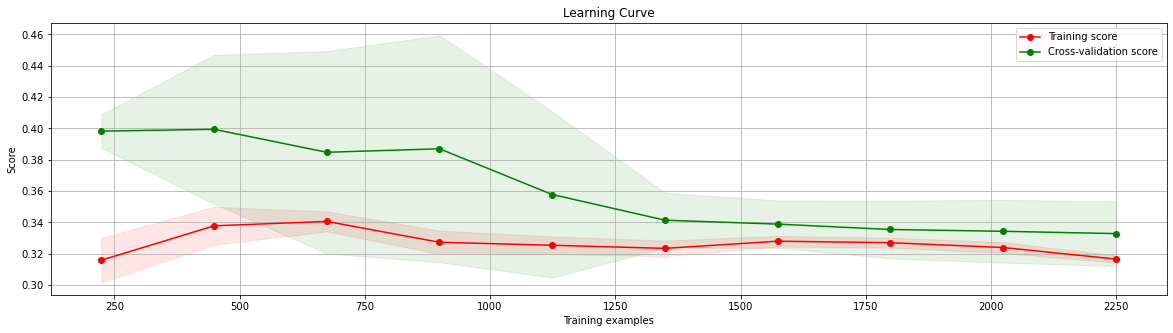

In [22]:
# Plot learning curve
fig = plt.figure(figsize=(20, 5))

plt.title('Learning Curve')
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()
#plt.ylim((0,1))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
plt.legend(loc="best")
plt.show()